In [ ]:
import networkx as nx
import pandas as pd
import pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from community import community_louvain
import numpy as np
import community
import random

**Analysis of Epinions social network**



**Creating the graph**


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
graph = nx.DiGraph()
epi_csv = pd.read_csv(r'gdrive/My Drive/soc-sign-epinions.txt',delimiter='\t')
epi_csv.columns = ['From','To','Weight']
# We check if the file has loaded
epi_csv.head()

,From,To,Weight
0,0,1,-1
1,1,128552,-1
2,2,3,1
3,4,5,-1
4,4,155,-1


In [ ]:
print('Row count is:',len(epi_csv.axes[0]))
print('Column count is:',len(epi_csv.axes[1]))

Row count is: 841372
Column count is: 3


In [ ]:
# Adding the edges.
for index,row in epi_csv.iterrows():
    graph.add_edges_from([(row[0],row[1])],weight = row[2])

KeyboardInterrupt: ignored

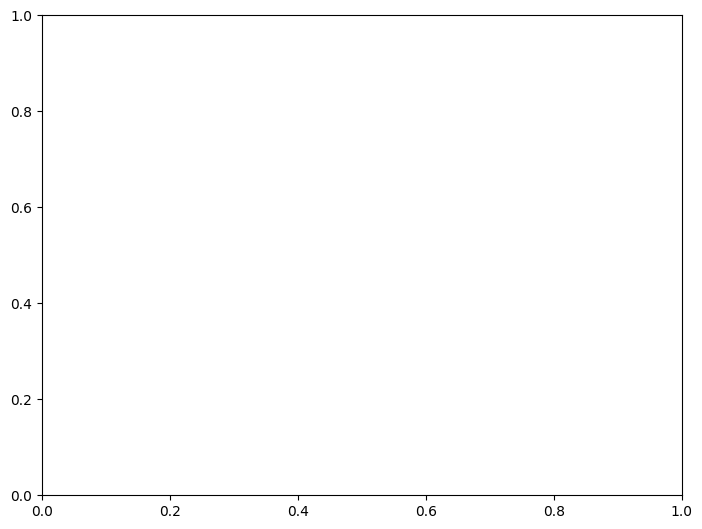

In [ ]:
nx.draw(graph)

**Creating the DataFrame containing degrees**


In [ ]:
# Positive and negative edges
Stats = pd.DataFrame(graph.out_degree(),columns=['From','Outdegree']).sort_values('From')
Stats_2 =  pd.DataFrame(graph.in_degree(),columns=['To','Indegree']).sort_values('To')
b= epi_csv.groupby('From',as_index=False)[['Weight']].sum().sort_values('From')
c= epi_csv.groupby('To',as_index=False)[['Weight']].sum().sort_values('To')
Stats = Stats.merge(b,on='From',how='left')
Stats_2 = Stats_2.merge(c,on='To',how='left')
Stats['Pos_out'] = (  Stats['Outdegree'] + Stats['Weight']  )/2
Stats['Neg_out'] = (  Stats['Outdegree'] - Stats['Weight']  )/2
Stats_2['Pos_in']= (Stats_2['Indegree']  + Stats_2['Weight'])/2
Stats_2['Neg_in']= (Stats_2['Indegree']  - Stats_2['Weight'])/2
Stats = pd.merge(Stats,Stats_2,left_on='From', right_on='To').drop('To', axis=1)
Stats = Stats.drop(['Weight_x','Weight_y'],axis=1)
Stats.fillna(0,inplace=True)
Stats.head()

,From,Outdegree,Pos_out,Neg_out,Indegree,Pos_in,Neg_in
0,0,1,0.0,1.0,0,0.0,0.0
1,1,1,0.0,1.0,2,1.0,1.0
2,2,1,1.0,0.0,1,1.0,0.0
3,3,0,0.0,0.0,4,4.0,0.0
4,4,14,9.0,5.0,1,1.0,0.0


In [ ]:
Stats.describe()
print(Stats.max(axis=0))

From         131827.0
Outdegree      2070.0
Pos_out        2070.0
Neg_out        1562.0
Indegree       3478.0
Pos_in         3338.0
Neg_in          540.0
dtype: float64


**Basic stats**


In [ ]:
print('Number of nodes:',graph.number_of_nodes())
print('Number of edges:',graph.number_of_edges())
print('Average Clustering:',nx.average_clustering(graph))
print('Transitivity:',nx.transitivity(graph))
print('Density:',nx.density(graph))

Number of nodes: 131828
Number of edges: 841372
Average Clustering: 0.09561744905322256
Transitivity: 0.07428166527700729
Density: 4.841456374018419e-05


**Edge weight distribution**


<AxesSubplot:ylabel='Frequency'>

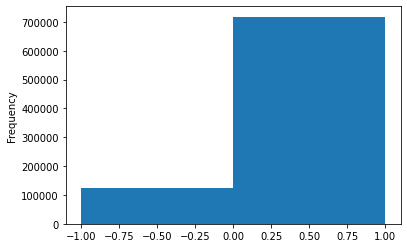

In [ ]:
epi_csv['Weight'].plot.hist(bins=2, alpha=1)

**Log-Log plots of degrees**


Out degree and indegree relationship, relationship between positive and negative weighted outgoing edges in the network and relationship between positive and negative ingoing edges.

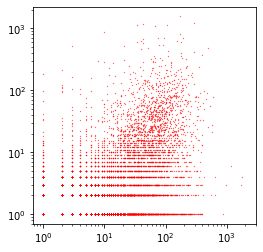

In [ ]:
#Positive and negative Out degree
plt.figure(figsize=(4,4))
plt.plot(Stats['Pos_out'],Stats['Neg_out'],'ro',markersize=0.25)
plt.xscale('log')
plt.yscale('log')

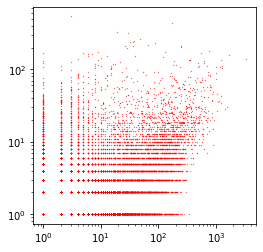

In [ ]:
#Positive and negative In degree
plt.figure(figsize=(4,4))
plt.plot(Stats['Pos_in'],Stats['Neg_in'],'ro',markersize=0.25)
plt.xscale('log')
plt.yscale('log')

Out degree and indegree relationship.

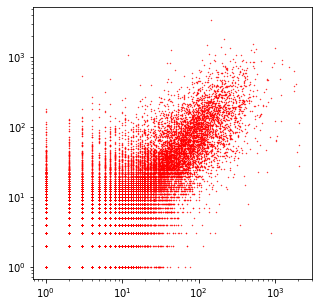

In [ ]:
#Out degree and In degree relationship
plt.figure(figsize=(5,5))
plt.plot(Stats['Outdegree'],Stats['Indegree'],'ro',markersize=0.4)
plt.xscale('log')
plt.yscale('log')

**Plotting the assortativity coefficients of the nodes.**


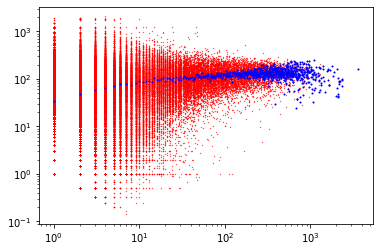

In [ ]:
Deg_cor = nx.average_neighbor_degree(graph,target='out')
dict_list = []
for key, value in Deg_cor.items():
    temp = [key,value]
    temp[0] = graph.degree(key,'out')
    dict_list.append(temp)
dfa1 = pd.DataFrame(dict_list,columns =['Outdegree','Average neighbors outdegree'])
dfa2 = dfa1.groupby('Outdegree',as_index=False)['Average neighbors outdegree'].mean()
plt.plot(dfa1['Outdegree'],dfa1['Average neighbors outdegree'],'ro',markersize=0.3)
plt.plot(dfa2['Outdegree'],dfa2['Average neighbors outdegree'],'bo',markersize=1)
plt.xscale('log')
plt.yscale('log')

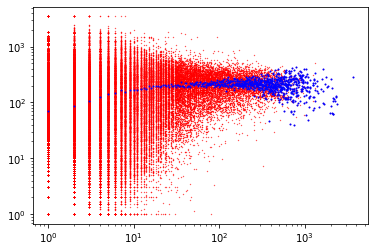

In [ ]:
Deg_cor = nx.average_neighbor_degree(graph,target='in')
dict_list = []
for key, value in Deg_cor.items():
    temp = [key,value]
    temp[0] = graph.degree(key,'in')
    dict_list.append(temp)
dfa1 = pd.DataFrame(dict_list,columns =['Indegree','Average neighbors indegree'])
dfa2 = dfa1.groupby('Indegree',as_index=False)['Average neighbors indegree'].mean()
plt.plot(dfa1['Indegree'],dfa1['Average neighbors indegree'],'ro',markersize=0.3)
plt.plot(dfa2['Indegree'],dfa2['Average neighbors indegree'],'bo',markersize=1)

plt.xscale('log')
plt.yscale('log')

**Checking assortativity**



In [ ]:
print(nx.degree_assortativity_coefficient(graph,'in','in'))
print(nx.degree_assortativity_coefficient(graph,'out','out'))

0.005121469550551876
-0.030516704380786377


In [ ]:
nx.degree_assortativity_coefficient(graph)

-0.06430169476171486

**Checking the power law for In-degree**

<AxesSubplot:>

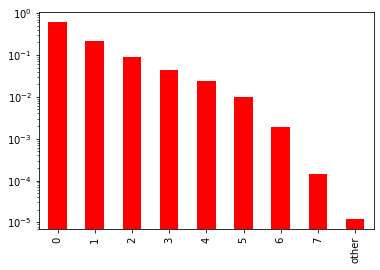

In [ ]:
import math
pos = Stats['Indegree'][Stats['Indegree'] != 0]
pos = pos.transform(lambda x: math.floor(math.log(x)) )

prob = pos.value_counts(normalize=True)
threshold = 0.0001
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar',log=True,color='r')

**Finding the power law coefficient of the indegree**

In [ ]:
import math
import igraph

pos = Stats['Indegree'][Stats['Indegree'] != 0]
igraph.power_law_fit(pos)

FittedPowerLaw(continuous=False, alpha=1.7049436066757273, xmin=1.0, L=-197839.7497898456, D=0.02086119220655669, p=0.0)

**Size of components for bowtie structure**

In [ ]:
SCC = max(nx.strongly_connected_components(graph), key=len)
print('Size of maximal strongly connected component is ' + str(len(SCC)))
WCC = max(nx.weakly_connected_components(graph), key=len)
print('Size of maximal weakly connected component is ' + str(len(WCC)))
DIF = list(set(WCC)-set(SCC))
OUT_C = []
IN_C = []
IN = 0
OUT = 0
for index, node1 in enumerate(DIF):
    for index2, node2 in enumerate(SCC):

        if graph.has_edge(node1,node2):
            OUT+=1
            OUT_C.append(node2)
            break
        elif graph.has_edge(node2,node1):
            IN+=1
            IN_C.append(node1)
            break


TND = len(DIF)-IN-OUT
print(IN,OUT,TND)

Size of maximal strongly connected component is 41441
Size of maximal weakly connected component is 119130
29732 37682 10275


**Community detection in graph**

In [ ]:
SCC = max(nx.strongly_connected_components(graph), key=len)
scc_com = graph.subgraph(SCC).copy()
scc2 = nx.Graph(scc_com)

# Removing the weights.

for u,v,d in scc2.edges(data=True):
    d['weight']=1

communities =community_louvain.best_partition(scc2,random_state=5)

In [ ]:
print(set(communities.values()))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
ind_graph = community_louvain.induced_graph(communities, scc2)

inv_map = dict()
for key, value in communities.items():
    inv_map.setdefault(value, list()).append(key)

# Removing the small communities

inv_map2 = {key:val for key, val in inv_map.items() if len(val) >= 100}
sizes = np.array([len(inv_map2[k]) for k in list(inv_map2.keys())])

# Removing edges from the graph:

inv_keys = [key for key in inv_map2]
ind_nodes = list(ind_graph.nodes())
for node in ind_nodes:
    if node not in inv_keys:
        ind_graph.remove_node(node)

In [ ]:
community_louvain.modularity(communities,scc2)

0.4328499720766367

**Getting the sizes of the communities**

In [ ]:
print(sizes)

[10032 10540   453 11587  4309   221   143   945   311   111   124]


**Checking power law for outdegree**

<AxesSubplot:>

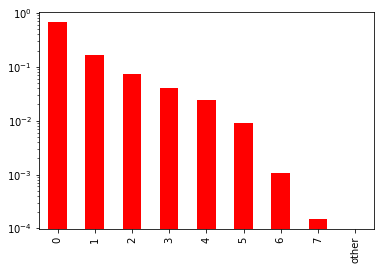

In [ ]:
import math
pos = Stats['Outdegree'][Stats['Outdegree'] != 0]
pos = pos.transform(lambda x: math.floor(math.log(x)) )

prob = pos.value_counts(normalize=True)
threshold = 0.0001
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar',log=True,color='r')

In [ ]:
import math
import igraph
pos = Stats['Outdegree'][Stats['Outdegree'] != 0]
igraph.power_law_fit(pos)

FittedPowerLaw(continuous=False, alpha=1.7290327710653879, xmin=2.0, L=-133428.12747064946, D=0.019071101789395528, p=0.0)

**Checking the rich club effect**

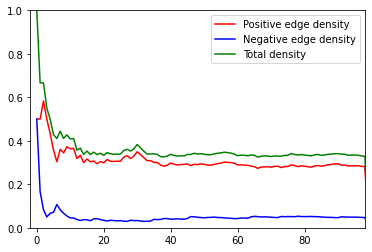

0.6515615431720759

In [ ]:
# We want to see the rich club effect in the 100 edges with the highest indegree.
picked = 100
rce1 = Stats[['From','Indegree']].sort_values(by=['Indegree'], ascending=False)[0:picked]
rich = list(rce1.From.values)
rece_graph = graph.subgraph(rich).copy()
# Dropping first value

densities = np.zeros((3,picked))
pos_edges = 0
neg_edges = 0
for rank, node1 in enumerate(rich[1::]):

    for rank2, node2 in enumerate(rich[:rank+1]):
        if graph.has_edge(node1, node2):
            if graph[node1][node2]['weight'] == 1:
                pos_edges += 1
            else:
                neg_edges += 1
        if graph.has_edge(node2, node1):
            if graph[node2][node1]['weight'] == 1:
                pos_edges += 1
            else:
                neg_edges += 1

    densities[0][rank] = pos_edges/(rank+2)/(rank+1)
    densities[1][rank] = neg_edges/(rank+2)/(rank+1)
    densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)


plt.plot( [i for i in range(0,picked)],densities[0,],'r-',label='Positive edge density')
plt.plot( [i for i in range(0,picked)],densities[1,],'b-',label='Negative edge density')
plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
plt.legend(loc="upper right")
plt.ylim((0,1))
plt.xlim((-2,picked-2))
plt.show()


# Checking the one sidedness
nx.reciprocity(rece_graph)





**Negative rich club**

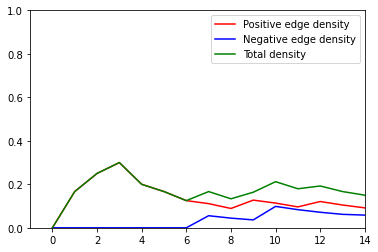

In [ ]:
# We want to see the rich club effect in the 100 edges with the highest negative_degree.
picked = 16
rce2 = Stats[['From','Neg_in']].sort_values(by=['Neg_in'], ascending=False)[4:picked+4]
rich = list(rce2.From.values)
# Dropping first value

densities = np.zeros((3,picked))
pos_edges = 0
neg_edges = 0

for rank, node1 in enumerate(rich[1::]):

    for rank2, node2 in enumerate(rich[:rank+1]):
        if graph.has_edge(node1, node2):
            if graph[node1][node2]['weight'] == 1:
                pos_edges += 1
            else:
                neg_edges += 1
        if graph.has_edge(node2, node1):
            if graph[node2][node1]['weight'] == 1:
                pos_edges += 1
            else:
                neg_edges += 1


    densities[0][rank] = pos_edges/(rank+2)/(rank+1)
    densities[1][rank] = neg_edges/(rank+2)/(rank+1)
    densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)


plt.plot( [i for i in range(0,picked)],densities[0,],'r-',label='Positive edge density')
plt.plot( [i for i in range(0,picked)],densities[1,],'b-',label='Negative edge density')
plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
plt.legend(loc="upper right")
plt.ylim((0,1))
plt.xlim((-1,picked-2))
plt.show()



**Simulating the adoption of a behaviour.**

In [ ]:
# Let top 200 out of 300 people adopt a certain opinion
import random
random.seed(5)
x=len(Stats)
op1 = Stats[['From','Pos_in']].sort_values(by=['Pos_in'], ascending=False)[0:300]
op2 = Stats[['From','Neg_in']].sort_values(by=['Neg_in'], ascending=False)[0:100]
adopters =  random.sample(list(op1['From']), k=200) + random.sample(list(op2['From']), k=50)
Stats['Adopt'] = 0
Stats['Heard'] = 0
Stats['Adopted'] = 0
for node in adopters :
    Stats.loc[node-1,'Adopt'] = 1

Total_adopters = 250
c = []
change = True
threshold = 0.4
j=0
while change:
    new_adopters = 0
    for node in graph.nodes :
        if Stats.loc[x-1 if node-1==-1 else node-1,'Heard']== 0:
            Stats.at[x-1 if node-1==-1 else node-1,'Heard'] = j
        if Stats.loc[x-1 if node-1==-1 else node-1,'Adopt'] == 0 and graph.out_degree(node)!= 0:
            trust_ch = 0
            no_out = graph.out_degree(node)
            for outgoing in graph.successors(node):
                if Stats.loc[outgoing-1,'Adopt'] == 1:
                    trust_ch += graph.get_edge_data(node,outgoing).get('weight')
            if trust_ch / no_out > threshold:
                Stats.at[x-1 if node-1==-1 else node-1,'Adopt'] = 1
                Stats.at[x-1 if node-1==-1 else node-1,'Adopted'] = j
                new_adopters += 1
    c.append(new_adopters)
    j+=1
    print('The number of new adopters at step ' + str(j) + ' is ' + str(new_adopters))
    if new_adopters == 0:
        change = False



The number of new adopters at step 1 is 8782
The number of new adopters at step 2 is 665
The number of new adopters at step 3 is 229
The number of new adopters at step 4 is 96
The number of new adopters at step 5 is 45
The number of new adopters at step 6 is 94
The number of new adopters at step 7 is 329
The number of new adopters at step 8 is 529
The number of new adopters at step 9 is 1362
The number of new adopters at step 10 is 1548
The number of new adopters at step 11 is 961
The number of new adopters at step 12 is 845
The number of new adopters at step 13 is 906
The number of new adopters at step 14 is 1384
The number of new adopters at step 15 is 1327
The number of new adopters at step 16 is 1283
The number of new adopters at step 17 is 1093
The number of new adopters at step 18 is 1789
The number of new adopters at step 19 is 3048
The number of new adopters at step 20 is 3577
The number of new adopters at step 21 is 3463
The number of new adopters at step 22 is 4769
The number

**Average time taken to adopt an opinion**

In [ ]:
Times = Stats.loc[Stats['Heard'] != 0]
Times = Times.loc[Times['Adopted'] != 0]

print(Times['Adopted'].mean()-Times['Heard'].mean())

17.403463165315475


**Adoption of behaviour in the out component**

In [ ]:
from statistics import mean

def adopted(node):
    return int(Stats.loc[node-1,'Adopt'] == 1)

print(round(1-mean(list(map(adopted,OUT_C))),5))

0.2718


**Adoption of behaviours in small communities**

In [ ]:
comm = np.zeros((6,3))
i = 0
inv_mapp = {key:val for key, val in inv_map.items() if len(val) >= 100 and len(val) <500}
for key, value in inv_mapp.items():
    comm[i][0] = key
    comm[i][1] = len(value)
    comm[i][2] = round(1-mean(list(map(adopted,value))),2)
    i+=1

comm = pd.DataFrame(comm,columns=['Community','Size','Rate of adoption'])
comm

,Community,Size,Rate of adoption
0,2.0,453.0,0.94
1,7.0,221.0,0.95
2,11.0,143.0,0.94
3,18.0,311.0,0.94
4,35.0,111.0,0.94
5,44.0,124.0,0.93


**Producing plot of behaviour adoption**

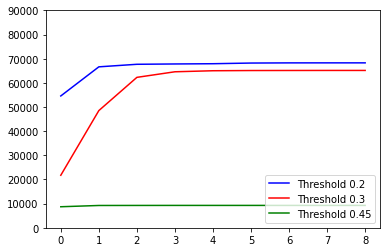

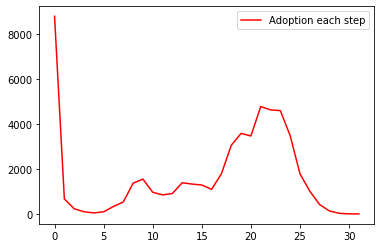

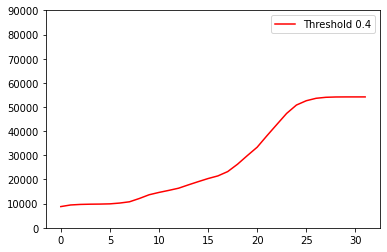

In [ ]:
c02 = np.cumsum([250+54322,12052,1054,135,102,276,69,8,2])
c025 = np.cumsum([250+21498,26766,13754,2312,428,87,21,16,2])
c05 = np.cumsum([250+8463,527,16,12,0,0,0,0,0])
d = [i for i in range (0,9)]
plt.plot(d,c02,'b-',label='Threshold 0.2')
plt.plot(d,c025,'r-',label='Threshold 0.3')
plt.plot(d,c05,'g-',label='Threshold 0.45')
plt.legend(loc="lower right")
plt.ylim((0,90000))
plt.show()

plt.plot( [i for i in range(0,len(c))],c,'r-',label='Adoption each step')
plt.legend(loc="upper right")
plt.show()
plt.plot( [i for i in range(0,len(c))],np.cumsum(c),'r-',label='Threshold 0.4')
plt.legend(loc="upper right")
plt.ylim((0,90000))
plt.show()

**Predicting the trustability of new node**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import random
#temp_graph=nx.Graph()
n=graph.number_of_nodes()
to_node=n+1
for i in range(7):
  from_node=random.randrange(n)
  wei=random.choice([1,-1])
  graph.add_edges_from([(from_node, to_node)],weight=wei)
  epi_csv=epi_csv.append({'From':from_node,'To':to_node,'Weight':wei},ignore_index = True)
  #df = df.append(df2, ignore_index = True)
  #graph.add_edges_from([(row[0],row[1])],weight = row[2])

In [ ]:
print('Number of nodes:',graph.number_of_nodes())
print('Number of edges:',graph.number_of_edges())

Number of nodes: 131830
Number of edges: 841386


In [ ]:
# Positive and negative edges
Stats = pd.DataFrame(graph.out_degree(),columns=['From','Outdegree']).sort_values('From')
Stats_2 =  pd.DataFrame(graph.in_degree(),columns=['To','Indegree']).sort_values('To')
b= epi_csv.groupby('From',as_index=False)[['Weight']].sum().sort_values('From')
c= epi_csv.groupby('To',as_index=False)[['Weight']].sum().sort_values('To')
Stats = Stats.merge(b,on='From',how='left')
Stats_2 = Stats_2.merge(c,on='To',how='left')
Stats['Pos_out'] = (  Stats['Outdegree'] + Stats['Weight']  )/2
Stats['Neg_out'] = (  Stats['Outdegree'] - Stats['Weight']  )/2
Stats_2['Pos_in']= (Stats_2['Indegree']  + Stats_2['Weight'])/2
Stats_2['Neg_in']= (Stats_2['Indegree']  - Stats_2['Weight'])/2
Stats = pd.merge(Stats,Stats_2,left_on='From', right_on='To').drop('To', axis=1)
Stats = Stats.drop(['Weight_x','Weight_y'],axis=1)
Stats.fillna(0,inplace=True)
Stats.tail()

,From,Outdegree,Pos_out,Neg_out,Indegree,Pos_in,Neg_in
131825,131825,1,1.0,0.0,0,0.0,0.0
131826,131826,0,0.0,0.0,1,1.0,0.0
131827,131827,1,1.0,0.0,0,0.0,0.0
131828,131829,0,0.0,0.0,7,3.0,4.0
131829,131830,0,0.0,0.0,7,3.0,4.0


In [ ]:
pos=Stats.iloc[len(Stats.index)-1,5]
neg=Stats.iloc[len(Stats.index)-1,6]
if(pos-neg>=2):
  print("Node ",Stats.iloc[len(Stats.index)-1,0]," is trusted")
else:
  print("Node ",Stats.iloc[len(Stats.index)-1,0]," is not trusted")

Node  131830  is not trusted
